<a href="https://colab.research.google.com/github/EnigMATHic/MathsAdventCalendar/blob/main/AdventCalNursing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [130]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2
import numpy as np
import pandas as pd
import random

from random import seed
# seed random number generator
#started 2022

YearNOW='2022'
BlockNOW='S1B4'
Blocks=['SB2', 'S1B1', 'S1B2', 'S1B3', 'S1B4', 'WB1', 'S2B1', 'S2B2', 'S2B3', 'S2B4', 'SB1']
findBLOCK=Blocks.index(BlockNOW)
#calculate seed number based off block and year
seed(findBLOCK*int(YearNOW[-2:]))
np.random.seed(findBLOCK*int(YearNOW[-2:]))
numVAL=20

In [131]:
try:
  import qrcode
except:  
  !pip install pillow
  !pip install qrcode
  import qrcode

try:
  from gtts import gTTS
except:  
  !pip install gtts

try:
  from PIL import Image, ImageFont, ImageDraw 
except:  
  !pip install pillow
  from PIL import Image, ImageFont, ImageDraw 

try:
  import ffmpeg
except:
  !pip install ffmpeg-python
  import ffmpeg

In [132]:
# Import the required module for text 
# to speech conversion
from gtts import gTTS
  
# This module is imported so that we can 
# play the converted audio
import os

# Language in which you want to convert
language = 'en'

In [133]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


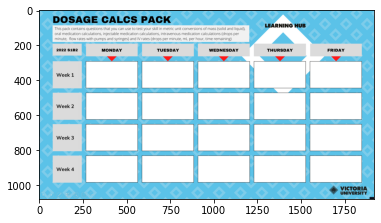

In [134]:
fpath="/content/gdrive/My Drive/Colab Notebooks/AdventCalendar/"

imgPLT = mpimg.imread(fpath+'NursingCalcsWebsterPacks.png')
imgplot = plt.imshow(imgPLT)

In [135]:
#Read input image
img = cv2.imread(fpath+'NursingCalcsWebsterPacks.png')

In [136]:
#convert from BGR to HSV color space
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#apply threshold
thresh = cv2.threshold(gray, 65, 255, cv2.THRESH_BINARY)[1]

# find contours and get one with area about 180*35
# draw all contours in green and accepted ones in red
contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = contours[0] if len(contours) == 2 else contours[1]
#area_thresh = 0
min_area = 0.95*50*75
max_area = 25*50*75
result = img.copy()
contlst=[]
for c in contours:
    area = cv2.contourArea(c)
    cv2.drawContours(result, [c], -1, (0, 255, 0), 10)
    if area > min_area and area < max_area:    
      cv2.drawContours(result, [c], -1, (0, 0, 255), 10)
      # Obtain bounding rectangle to get measurements
      x,y,w,h = cv2.boundingRect(c)
      # Find centroid
      M = cv2.moments(c)
      cX = int(M["m10"] / M["m00"])
      cY = int(M["m01"] / M["m00"])
      #print(cX,cY) 
      contlst.append([cX,cY])         
# save result
cv2.imwrite(fpath+"box_found.png", result)

True

In [137]:
#identify the centroids that we want to use
x=[item[0] for item in contlst]
y=[item[-1] for item in contlst]
contDIST=[(x2 - x1)^2+(y2 - y1)^2 for x1, x2, y1, y2 in zip(x, x[1:], y, y[1:])]
contDIST
#remove centroids that are close together - should duplicate boxes be detected
contFOUND=[i for i,v in enumerate(contDIST) if abs(v) < 5]
contFOUND
x=[x[i] for i in contFOUND]
y=[y[i] for i in contFOUND]

contXY=list(zip(x, y))

In [138]:
#create randomly generated values for 
#SR - stock required, 
#SRM_DOSE - stock required, per dose
#SRM_DAY - stock required, per day 
#SRMpKG_DOSE - stock required, per kilogram mass of patient, per dose
#SRMpKG_DAY - stock required, per kilogram mass of patient, per day 
#SS- stock strength 
#SSM - stock strength (mass)
#SSV - stock strength (volume)
#SSDF - stock drop factor
#PERC- percentage concentration (not usually used in calcs)
#MM - patient mass
#TTo -time/duration of delivery of dosage
#TTf -longest time/duration of delivery of dosage
#DD - doses

#create dictionary of ranges of values for quantities for each question
valDICT={'SRMmg':{'min': 100, 'max':2000, 'unit':' mg'},
         'SRMg':{'min': 0.1, 'max':2, 'unit':' g'},
         'SRM_DOSEmg':{'min': 100, 'max':2000, 'unit':' mg'},
         'SRM_DOSEg':{'min': 0.1, 'max':2, 'unit':' g'},    
         'SRM_DAYmg':{'min': 400, 'max':8000, 'unit':' mg'},
         'SRM_DAYg':{'min': 0.4, 'max':8, 'unit':' g'}, 
         'SRMpKG_DOSEmg':{'min': 0.1, 'max':0.8, 'unit':' mg/ kg/ dose'},        
         'SRMpKG_DAYmg':{'min': 0.1, 'max':0.8, 'unit':' mg/ kg/ day'},
         'SRVml':{'min': 2, 'max':10, 'unit':' mL'},
         'SSMmg':{'min': 10, 'max':100, 'unit':' mg'},
         'SSMg':{'min': 0.010, 'max':0.100, 'unit':' g'},
         'SSMVmgPml':{'min': 10, 'max':100, 'unit':' mg/ml'},
         'SSMVgPml':{'min': 0.010, 'max':0.100, 'unit':' g/ml'},
         'SSVml':{'min': 2, 'max':10, 'unit':' mL'},
         'SSDF':{'min': 20, 'max':60, 'unit':''},
         'MM':{'min': 10, 'max':50, 'unit':' kg'},
         'TToDOSEmin':{'min': 30, 'max': 180, 'unit':' min'},                                    
         'TTomin':{'min': 2, 'max':3, 'unit':' min'},
         'TTfmin':{'min': 4, 'max':5, 'unit':' min'},   
         'TTohr':{'min': 2, 'max':3, 'unit':' hrs'},
         'TTfhr':{'min': 4, 'max':5, 'unit':' hrs'}, 
         'DD':{'min': 2, 'max':8, 'unit':' doses'},  
         'PERC':{'min': 2, 'max':8, 'unit':'%'}  
}

randvalDICT={'SRMmg':[str(i//10*10)+str(valDICT['SRMmg']['unit']) for i in random.sample(range(valDICT['SRMmg']['min'], valDICT['SRMmg']['max']), numVAL)],
             'SRMg':[str(round(i,2))+str(valDICT['SRMg']['unit']) for i in list(np.random.uniform(valDICT['SRMg']['min'],valDICT['SRMg']['max'],numVAL))],
             'SRM_DOSEmg':[str(i//10*10)+str(valDICT['SRM_DOSEmg']['unit']) for i in random.sample(range(valDICT['SRM_DOSEmg']['min'], valDICT['SRM_DOSEmg']['max']), numVAL)],
             'SRM_DOSEg':[str(round(i,2))+str(valDICT['SRM_DOSEg']['unit']) for i in list(np.random.uniform(valDICT['SRM_DOSEg']['min'],valDICT['SRM_DOSEg']['max'],numVAL))],
             'SRM_DAYmg':[str(i//10*10)+str(valDICT['SRM_DAYmg']['unit']) for i in random.sample(range(valDICT['SRM_DAYmg']['min'], valDICT['SRM_DAYmg']['max']), numVAL)],
             'SRM_DAYg':[str(round(i,2))+str(valDICT['SRM_DAYg']['unit']) for i in list(np.random.uniform(valDICT['SRM_DAYg']['min'],valDICT['SRM_DAYg']['max'],numVAL))],
             'SRMpKG_DOSEmg':[str(round(i,2))+str(valDICT['SRMpKG_DOSEmg']['unit']) for i in list(np.random.uniform(valDICT['SRMpKG_DOSEmg']['min'],valDICT['SRMpKG_DOSEmg']['max'],numVAL))],
             'SRMpKG_DAYmg':[str(round(i,2))+str(valDICT['SRMpKG_DAYmg']['unit']) for i in list(np.random.uniform(valDICT['SRMpKG_DAYmg']['min'],valDICT['SRMpKG_DAYmg']['max'],numVAL))],
             'SRVml':[str(i/10)+str(valDICT['SRVml']['unit']) for i in random.sample(range(valDICT['SRVml']['min']*10, valDICT['SRVml']['max']*10), numVAL)],
             'SSMmg':[str(i//10*10)+str(valDICT['SSMmg']['unit']) for i in random.sample(range(valDICT['SSMmg']['min'], valDICT['SSMmg']['max']), numVAL)],
             'SSMg':[str(round(i,2))+str(valDICT['SSMg']['unit']) for i in list(np.random.uniform(valDICT['SSMg']['min'],valDICT['SSMg']['max'],numVAL))],
             'SSMVmgPml':[str(i//10*10)+str(valDICT['SSMVmgPml']['unit']) for i in random.sample(range(valDICT['SSMVmgPml']['min'], valDICT['SSMVmgPml']['max']), numVAL)],
             'SSMVgPml':[str(round(i,2))+str(valDICT['SSMVgPml']['unit']) for i in list(np.random.uniform(valDICT['SSMVgPml']['min'],valDICT['SSMVgPml']['max'],numVAL))],             
             'SSVml':[str(i/10)+str(valDICT['SSVml']['unit']) for i in random.sample(range(valDICT['SSVml']['min']*10, valDICT['SSVml']['max']*10), numVAL)],
             'SSDF':[str(i//10*10)+str(valDICT['SSDF']['unit']) for i in random.sample(range(valDICT['SSDF']['min'], valDICT['SSDF']['max']), numVAL)],
             'MM':[str(i//10*10)+str(valDICT['MM']['unit']) for i in random.sample(range(valDICT['MM']['min'], valDICT['MM']['max']), numVAL)],
             'TToDOSEmin':[str(round(i/100))+str(valDICT['TTomin']['unit']) for i in random.sample(range(valDICT['TTomin']['min']*100, valDICT['TTomin']['max']*100), numVAL)],             
             'TTomin':[str(round(i/100))+str(valDICT['TTomin']['unit']) for i in random.sample(range(valDICT['TTomin']['min']*100, valDICT['TTomin']['max']*100), numVAL)],
             'TTfmin':[str(round(i/100))+str(valDICT['TTfmin']['unit']) for i in random.sample(range(valDICT['TTfmin']['min']*100, valDICT['TTfmin']['max']*100), numVAL)],
             'TTohr':[str(round(i/100))+str(valDICT['TTohr']['unit']) for i in random.sample(range(valDICT['TTohr']['min']*100, valDICT['TTohr']['max']*100), numVAL)],
             'TTfhr':[str(round(i/100))+str(valDICT['TTfhr']['unit']) for i in random.sample(range(valDICT['TTfhr']['min']*100, valDICT['TTfhr']['max']*100), numVAL)],
             'DD':[str(round(i//200*2))+str(valDICT['DD']['unit']) for i in random.sample(range(valDICT['DD']['min']*100, (valDICT['DD']['max']+1)*100), numVAL)],
             'PERC':[str(i//10)+str(valDICT['PERC']['unit']) for i in random.sample(range(valDICT['PERC']['min']*10, valDICT['PERC']['max']*10), numVAL)]
             }
    

In [139]:
#load the questions from csv

NurseQuest=pd.read_csv(fpath+'NurseQ_v01.csv')
NurseQuest 

,General Q
0,"If SRMmg are ordered for an injection, and sto..."
1,A patient needs a dose of SRMg of medication. ...
2,A flask of SRVml of PERC dextrose in saline is...
3,A child weighing MM is prescribed SRMpKG_DOSEm...
4,A patient is prescribed a medication for SRMpK...
5,A MM infant is ordered a medication for SRMpKG...
6,A patient needs SRMmg of a medication. Accordi...
7,A patient is prescribed a medication with a do...
8,How many mg per mL will be infused for a solut...


In [140]:
NurseQuest['Updated Q']=NurseQuest['General Q']

In [141]:
varQ=list(valDICT.keys())
for i, ival in enumerate(varQ):
  mask = NurseQuest['General Q'].str.contains(ival, na=True)
  maskLIST=list(NurseQuest[mask].index)
  #print(maskLIST, i, ival)
  for m in maskLIST:
    mytext=NurseQuest['Updated Q'].iloc[m].replace(ival,randvalDICT[ival][m])
    NurseQuest['Updated Q'].iloc[m]=mytext
    # Passing the text and language to the engine, 
    # here we have marked slow=False. Which tells 
    # the module that the converted audio should 
    # have a high speed
    myobj = gTTS(text=mytext, lang=language, slow=False)
    # Saving the converted audio in a mp3 file named
NurseQuest

,General Q,Updated Q
0,"If SRMmg are ordered for an injection, and sto...","If 910 mg are ordered for an injection, and st..."
1,A patient needs a dose of SRMg of medication. ...,A patient needs a dose of 1.06 g of medication...
2,A flask of SRVml of PERC dextrose in saline is...,A flask of 8.2 mL of 7% dextrose in saline is ...
3,A child weighing MM is prescribed SRMpKG_DOSEm...,A child weighing 40 kg is prescribed 0.22 mg/ ...
4,A patient is prescribed a medication for SRMpK...,A patient is prescribed a medication for 0.13 ...
5,A MM infant is ordered a medication for SRMpKG...,A 40 kg infant is ordered a medication for 0.5...
6,A patient needs SRMmg of a medication. Accordi...,A patient needs 120 mg of a medication. Accord...
7,A patient is prescribed a medication with a do...,A patient is prescribed a medication with a do...
8,How many mg per mL will be infused for a solut...,How many mg per mL will be infused for a solut...


In [142]:
varQ=list(valDICT.keys())
for i, ival in enumerate(varQ):
  mask = NurseQuest['General Q'].str.contains(ival, na=True)
  maskLIST=list(NurseQuest[mask].index)
  #print(maskLIST, i, ival)
  for m in maskLIST:
    mytext=NurseQuest['Updated Q'].iloc[m].replace(ival,randvalDICT[ival][m])
    NurseQuest['Updated Q'].iloc[m]=mytext
NurseQuest

,General Q,Updated Q
0,"If SRMmg are ordered for an injection, and sto...","If 910 mg are ordered for an injection, and st..."
1,A patient needs a dose of SRMg of medication. ...,A patient needs a dose of 1.06 g of medication...
2,A flask of SRVml of PERC dextrose in saline is...,A flask of 8.2 mL of 7% dextrose in saline is ...
3,A child weighing MM is prescribed SRMpKG_DOSEm...,A child weighing 40 kg is prescribed 0.22 mg/ ...
4,A patient is prescribed a medication for SRMpK...,A patient is prescribed a medication for 0.13 ...
5,A MM infant is ordered a medication for SRMpKG...,A 40 kg infant is ordered a medication for 0.5...
6,A patient needs SRMmg of a medication. Accordi...,A patient needs 120 mg of a medication. Accord...
7,A patient is prescribed a medication with a do...,A patient is prescribed a medication with a do...
8,How many mg per mL will be infused for a solut...,How many mg per mL will be infused for a solut...


In [143]:
import io
import os
import subprocess

my_image = Image.open(fpath+"Border/Simple.png")
title_font = ImageFont.truetype(fpath+"arial.ttf", 32)
lineWIDTH=50

for i in range(len(NurseQuest['Updated Q'])):
  #capture and record audio (text to speech)
    # Passing the text and language to the engine, 
    # here we have marked slow=False. Which tells 
    # the module that the converted audio should 
    # have a high speed
    mytext=NurseQuest['Updated Q'].iloc[i].replace('/',' per ')
    #print(mytext)
    myobj = gTTS(text=mytext, lang=language, slow=True)

  #design written question
    title_text = NurseQuest['Updated Q'].iloc[i]
    idxSPACE = [i for i, c in enumerate(title_text) if c == " "]
    lineNUM=[i//lineWIDTH for i, c in enumerate(title_text) if c == " "]
    lineBREAK=[j-i for i, j in zip(lineNUM[:-1], lineNUM[1:])]
    LSlineBREAK=[x for x, c in enumerate(lineBREAK) if c == 1]
    for ii in [idxSPACE[s]+1 for s in LSlineBREAK]:
        title_text = title_text[:ii].rstrip() + "\n" + title_text[ii:].lstrip()
    #print(title_text) 
    my_image = Image.open(fpath+"Border/Simple.png")
    image_editable = ImageDraw.Draw(my_image)
    image_editable.text((120,120), title_text, (0, 0, 255), title_font)

    # Saving the converted audio in a mp3 file named
    if i<9:
      audfname="TempAudio/Day0"+str(i+1)+".mp3"
      imgfname="TempCard/Day0"+str(i+1)+".png"
      outfname="BlockVideos/Day0"+str(i+1)+".mp4"
      qrcodename="TempQR/Day0"+str(i+1)+".png"
    else:
      audfname="TempAudio/Day"+str(i+1)+".mp3"
      imgfname="TempCard/Day"+str(i+1)+".png"      
      outfname="BlockVideos/Day"+str(i+1)+".mp4"
      qrcodename="TempQR/Day"+str(i+1)+".png"

    myobj.save(fpath+audfname)
    my_image.save(fpath+imgfname)
    #create videos of each of the questions
    subprocess.call(['ffmpeg', '-loop', '1', '-y', '-i', imgfname, '-i', audfname, '-shortest', '-pix_fmt', 'yuv420p', outfname])

    input_data = outfname
    #Creating an instance of qrcode
    qr = qrcode.QRCode(
            version=1,
            box_size=10,
            border=5)
    qr.add_data(input_data)
    qr.make(fit=True)
    img = qr.make_image(fill='black', back_color='white')
    img.save(fpath+qrcodename)
    

In [144]:
qrcodesimg = os.listdir(fpath+'TempQR')
im1 = Image.open(fpath+'NursingCalcsWebsterPacks.png')
back_im = im1.copy()
for q, qrc in enumerate(qrcodesimg):
  #get centre of boxes on calendar
  #print(q)
  #print(contXY[len(contXY)-q-1],qrc)
  im2 = Image.open(fpath+'TempQR'+'/'+qrc)
  im2dim=im2.size
  im2new=im2.resize(tuple([round(0.425*x) for x in im2dim]), Image.ANTIALIAS)
  im2newdim=im2new.size
  locQR=tuple(contXY[len(contXY)-q-1])[0]-im2newdim[0]//2,tuple(contXY[len(contXY)-q-1])[1]-im2newdim[1]//2
  back_im.paste(im2new, tuple(locQR[::1]))
back_im.save(fpath+'Calendar'+YearNOW[-2:]+'Block'+str(findBLOCK)+'.png', quality=95)

